In [1]:
# 📈 Create visualizations to explore data trends

import pandas as pd
import glob
import os
import geopy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 🧩 Split the dataset into training and testing sets

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error
)
from sklearn.preprocessing import OneHotEncoder

In [3]:
# 📥 Load dataset from CSV file

files=glob.glob("*.csv")

data=[pd.read_csv(file) for file in files]
df=pd.concat(data, ignore_index=True)

In [4]:
# 💡 Code logic explanation

# Check for null values

df.isna().sum()

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1129029
start_station_id      1129029
end_station_name      1175835
end_station_id        1175835
start_lat                   0
start_lng                   0
end_lat                  5442
end_lng                  5442
member_casual               0
dtype: int64

In [5]:
# 💡 Code logic explanation

# Check for duplicates 

df.duplicated().sum()

0

In [6]:
# 🧹 Handle missing or null values in the dataset

# Handdling missing values by replacing NaN with Unknown for station names and ids

df['start_station_name']=df['start_station_name'].fillna("Unknown")
df['start_station_id']=df['start_station_id'].fillna("Unknown")
df['end_station_name']=df['end_station_name'].fillna("Unknown")
df['end_station_id']=df['end_station_id'].fillna("Unknown")

# Dropping the records with Nan values since the count is minimal

df = df[df['end_lat'].notna() & (df['end_lat'] != '')]

In [7]:
# 👀 Preview first few rows of the dataset

df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7569BC890583FCD7,classic_bike,2025-01-21 17:23:54.538,2025-01-21 17:37:52.015,Wacker Dr & Washington St,KA1503000072,McClurg Ct & Ohio St,TA1306000029,41.883143,-87.637242,41.892592,-87.617289,member
1,013609308856B7FC,electric_bike,2025-01-11 15:44:06.795,2025-01-11 15:49:11.139,Halsted St & Wrightwood Ave,TA1309000061,Racine Ave & Belmont Ave,TA1308000019,41.929147,-87.649153,41.939743,-87.658865,member
2,EACACD3CE0607C0D,classic_bike,2025-01-02 15:16:27.730,2025-01-02 15:28:03.230,Southport Ave & Waveland Ave,13235,Broadway & Cornelia Ave,13278,41.948226,-87.664071,41.945529,-87.646439,member
3,EAA2485BA64710D3,classic_bike,2025-01-23 08:49:05.814,2025-01-23 08:52:40.047,Southport Ave & Waveland Ave,13235,Southport Ave & Roscoe St,13071,41.948226,-87.664071,41.943739,-87.664020,member
4,7F8BE2471C7F746B,electric_bike,2025-01-16 08:38:32.338,2025-01-16 08:41:06.767,Southport Ave & Waveland Ave,13235,Southport Ave & Roscoe St,13071,41.948226,-87.664071,41.943739,-87.664020,member


In [8]:
# ℹ️ Display dataset information and summary statistics

df.describe()

,start_lat,start_lng,end_lat,end_lng
count,5.534079e+06,5.534079e+06,5.534079e+06,5.534079e+06
mean,4.190316e+01,-8.764632e+01,4.190358e+01,-8.764661e+01
std,4.447890e-02,2.733866e-02,4.808185e-02,1.057933e-01
min,4.164000e+01,-8.789000e+01,3.550000e+01,-9.427000e+01
25%,4.188132e+01,-8.766000e+01,4.188186e+01,-8.766000e+01
50%,4.189776e+01,-8.764174e+01,4.189897e+01,-8.764182e+01
75%,4.193000e+01,-8.762979e+01,4.193000e+01,-8.762991e+01
max,4.207000e+01,-8.752000e+01,8.314000e+01,1.525300e+02


In [9]:
# 💡 Code logic explanation

df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [10]:
# 💡 Code logic explanation

# Convert the data types to datetime

df.loc[:, 'started_at'] = pd.to_datetime(df['started_at'])
df.loc[:, 'ended_at'] = pd.to_datetime(df['ended_at'])


# Add duration of the rides and only include rides with duration
df.loc[:, 'ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df = df[(df['ride_duration'] > 0) & (df['ride_duration']<=24*60)]

In [76]:
# 💡 Code logic explanation

df['day_of_week'] = df['started_at'].dt.day_name()
df['hour'] = df['started_at'].dt.hour
df['month'] = df['started_at'].dt.month
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
df['date'] = df['started_at'].dt.date

In [12]:
# 💡 Code logic explanation

# Earth radius in kilometers
R = 6371.0 

# Convert degrees to radians
lat1 = np.radians(df['start_lat'])
lon1 = np.radians(df['start_lng'])
lat2 = np.radians(df['end_lat'])
lon2 = np.radians(df['end_lng'])

# Haversine formula
dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

df['distance_km'] = R * c

In [13]:
# 💡 Code logic explanation

# speed (km/h) safe compute
df['speed_kmh'] = (df['distance_km'] / (df['ride_duration'] / 60)).replace([np.inf, -np.inf], np.nan)

# create categorical features as needed
df['rideable_type'] = df['rideable_type'].astype(str)
df['member_casual'] = df['member_casual'].astype(str)

### Exploratory Data Analysis

In [14]:
# 📊 Aggregate or summarize data by grouping columns

# Count of rides by type of ride

data= (
    df.groupby(['month','member_casual','rideable_type'])
      .agg(
          distance=('distance_km', 'mean'),
          total_rides=('ride_id','count'),
      )
      .reset_index()
)

In [15]:
# 📊 Aggregate or summarize data by grouping columns

# Calculating average monthly distance
monthly_avg = (
    df.groupby('month')[['ride_duration', 'distance_km']]
      .mean()
      .reset_index()
      .sort_values('month')
)

In [16]:
# 💡 Code logic explanation

avg_dur_12m = monthly_avg['ride_duration'].mean()
avg_dist_12m = monthly_avg['distance_km'].mean()

In [17]:
# 📊 Aggregate or summarize data by grouping columns

rides_count=df.groupby('member_casual')['member_casual'].count()
rides_perc=df['member_casual'].value_counts(normalize=True)

print(f"Total rides: {rides_count} \n Rides Percentage:\n {rides_perc}")

Total rides: member_casual
casual    1991294
member    3542534
Name: member_casual, dtype: int64 
 Rides Percentage:
 member    0.64016
casual    0.35984
Name: member_casual, dtype: float64


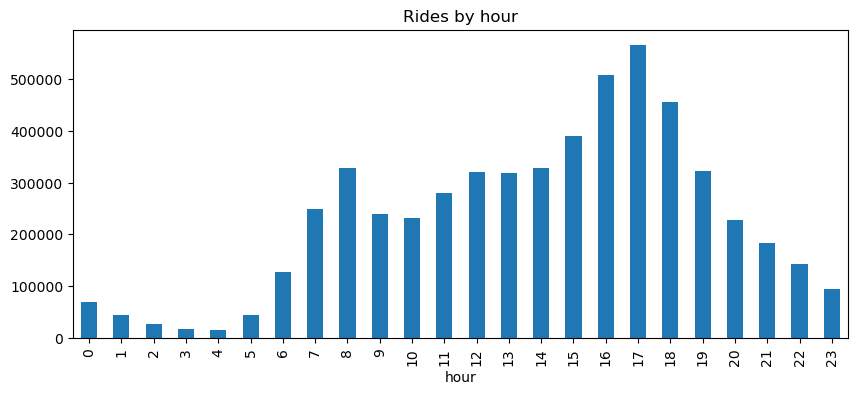

In [18]:
# 📊 Aggregate or summarize data by grouping columns

#Number of rides by hour

hourly = df.groupby('hour').size()
hourly.plot(kind='bar', figsize=(10,4))
plt.title('Rides by hour')
plt.show()

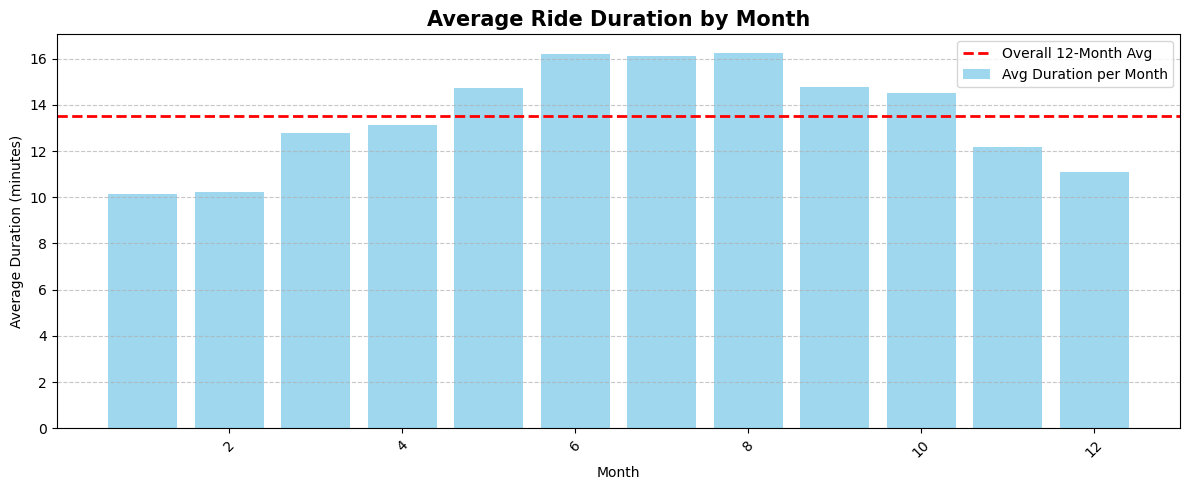

In [19]:
# 📈 Create visualizations to explore data trends

# cacluate and present the monthly avg duration and distance against the averages for the last 12 months

plt.figure(figsize=(12,5))
plt.bar(monthly_avg['month'], monthly_avg['ride_duration'], 
        color='skyblue', alpha=0.8, label='Avg Duration per Month')

# Add 12-month overall average line
plt.axhline(avg_dur_12m, color='red', linestyle='--', linewidth=2, label='Overall 12-Month Avg')

# Formatting
plt.title('Average Ride Duration by Month', fontsize=15, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Duration (minutes)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

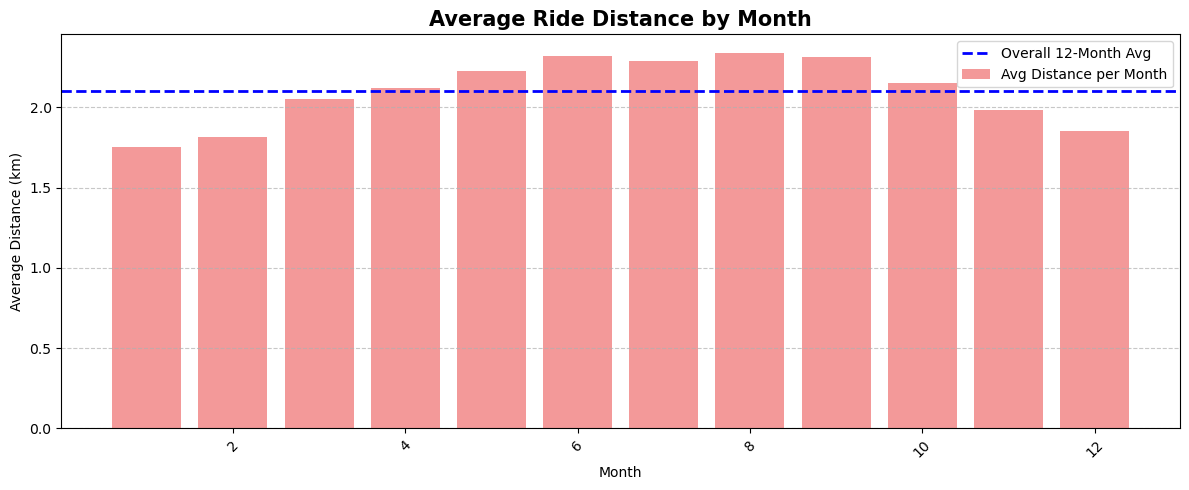

In [67]:
# 📈 Create visualizations to explore data trends

plt.figure(figsize=(12,5))
plt.bar(monthly_avg['month'], monthly_avg['distance_km'], 
        color='lightcoral', alpha=0.8, label='Avg Distance per Month')

# Add 12-month overall average line
plt.axhline(avg_dist_12m, color='blue', linestyle='--', linewidth=2, label='Overall 12-Month Avg')

# Formatting
plt.title('Average Ride Distance by Month', fontsize=15, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Distance (km)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

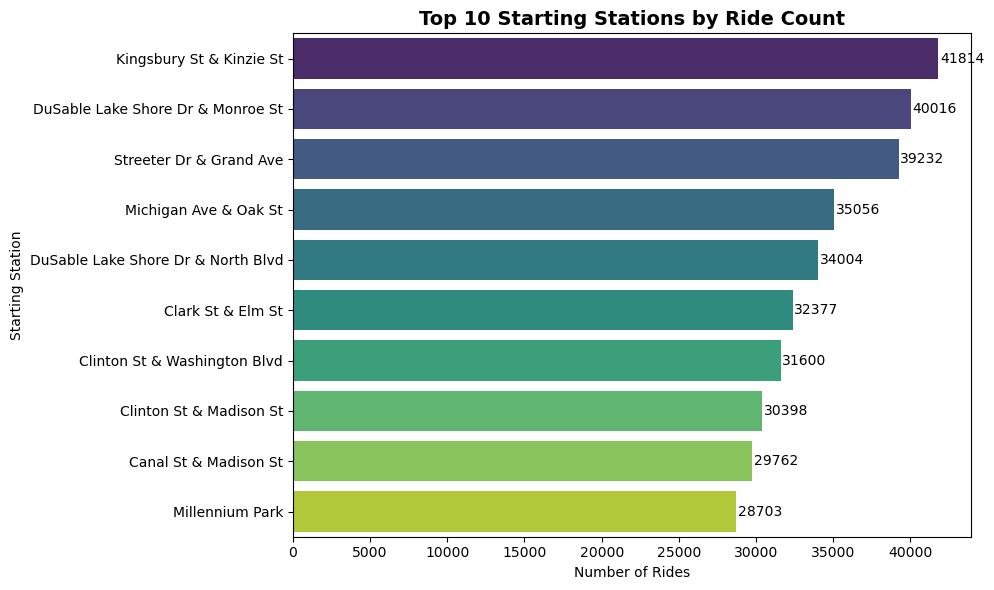

In [65]:
# 👀 Preview first few rows of the dataset

# Top 10 busiest departure stations 

data= (
      df.groupby('start_station_name')['ride_id']
      .count()
      .reset_index()
      .sort_values('start_station_name')
)

top_starting_station = (
    data[data['start_station_name'] != 'Unknown']
    .sort_values('ride_id', ascending=False)
    .head(10)
    
)

data_e= (
      df.groupby('end_station_name')['ride_id']
      .count()
      .reset_index()
      .sort_values('end_station_name')
)

top_ending_station = (
    data_e[data_e['end_station_name'] != 'Unknown']
    .sort_values('ride_id', ascending=False)
    .head(10)
    
)

plt.figure(figsize=(10, 6))

# Create barplot
sns.barplot(
    x='ride_id',
    y='start_station_name',
    data=top_starting_station,
    palette='viridis'
)

# Add titles and labels
plt.title('Top 10 Starting Stations by Ride Count', fontsize=14, fontweight='bold')
plt.xlabel('Number of Rides')
plt.ylabel('Starting Station')

# Add value labels to bars
for index, value in enumerate(top_starting_station['ride_id']):
    plt.text(value + 100, index, str(value), va='center')

# Tight layout for better spacing
plt.tight_layout()
plt.show()

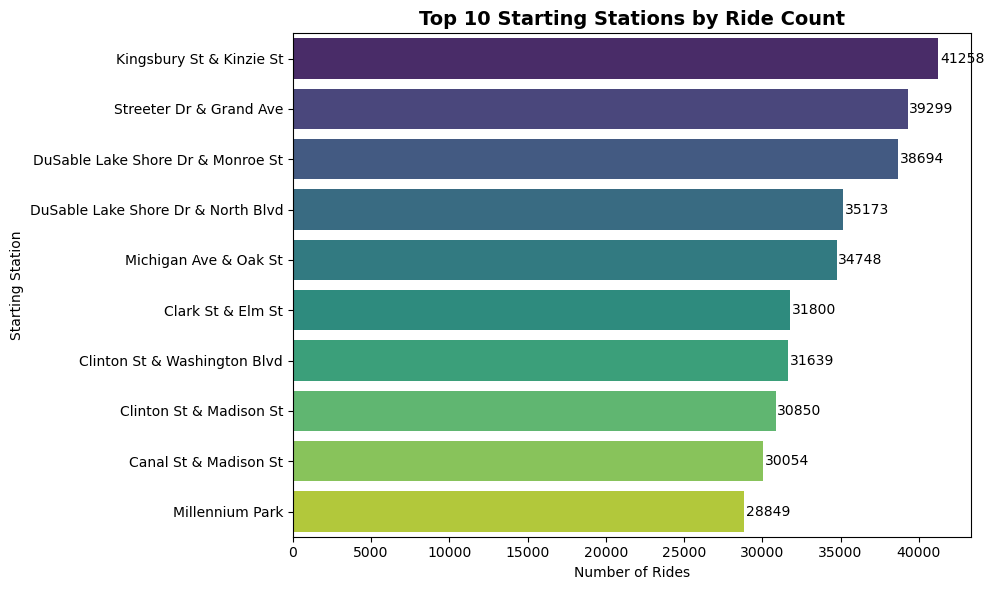

In [67]:
# 👀 Preview first few rows of the dataset

# Top 10 busiest arrival stations 

data= (
      df.groupby('end_station_name')['ride_id']
      .count()
      .reset_index()
      .sort_values('end_station_name')
)

top_ending_station = (
    data[data['end_station_name'] != 'Unknown']
    .sort_values('ride_id', ascending=False)
    .head(10)
    
)

plt.figure(figsize=(10, 6))

# Create barplot
sns.barplot(
    x='ride_id',
    y='end_station_name',
    data=top_ending_station,
    palette='viridis'
)

# Add titles and labels
plt.title('Top 10 Starting Stations by Ride Count', fontsize=14, fontweight='bold')
plt.xlabel('Number of Rides')
plt.ylabel('Starting Station')

# Add value labels to bars
for index, value in enumerate(top_ending_station['ride_id']):
    plt.text(value + 100, index, str(value), va='center')

# Tight layout for better spacing
plt.tight_layout()
plt.show()

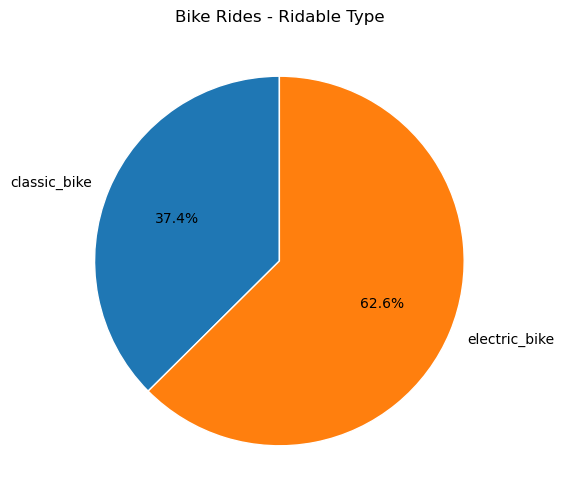

In [68]:
# 📊 Aggregate or summarize data by grouping columns

# Top 10 busiest arrival stations 

data = df.groupby('rideable_type')['ride_id'].count()

plt.figure(figsize=(6,6))
plt.pie(
    data,
    labels=data.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Bike Rides - Ridable Type")
plt.show()

In [71]:
# 📊 Aggregate or summarize data by grouping columns

# Most preferred bike ride by distance range
bins = [0, 1, 3, 5, 10, 20, df['distance_km'].max()]
labels = ['<1 km', '1–3 km', '3–5 km', '5–10 km', '10–20 km', '>20 km']

df['distance_range'] = pd.cut(df['distance_km'], bins=bins, labels=labels, include_lowest=True)

rideable_preference = (
    df.groupby(['distance_range', 'rideable_type'])['ride_id']
      .count()
      .reset_index()
      .rename(columns={'ride_id': 'ride_count'})
)

rideable_preference.sort_values(['distance_range', 'ride_count'], ascending=[True, False])

preferred_type = (
    rideable_preference.loc[
        rideable_preference.groupby('distance_range')['ride_count'].idxmax()
    ].reset_index(drop=True)
)

preferred_type

,distance_range,rideable_type,ride_count
0,<1 km,electric_bike,885416
1,1–3 km,electric_bike,1681221
2,3–5 km,electric_bike,564616
3,5–10 km,electric_bike,300547
4,10–20 km,electric_bike,30070
5,>20 km,electric_bike,569


## Modelling

### Forecasting the rides

In [20]:
# 📊 Aggregate or summarize data by grouping columns

df['start_ts_hour'] = df['started_at'].dt.floor('H')
hourly_counts = df.groupby('start_ts_hour').size().rename('rides').reset_index()
hourly_counts = hourly_counts.set_index('start_ts_hour').asfreq('H', fill_value=0).reset_index()

In [21]:
# 💡 Code logic explanation

hc = hourly_counts.copy()
hc['hour'] = hc['start_ts_hour'].dt.hour
hc['dayofweek'] = hc['start_ts_hour'].dt.dayofweek
hc['is_weekend'] = hc['dayofweek'].isin([5,6]).astype(int)

In [22]:
# 💡 Code logic explanation

# Lags - rides in the last 1 hour, day and same time last week
for lag in [1, 24, 24*7]:
    hc[f'lag_{lag}'] = hc['rides'].shift(lag)

# Rolling averages - last 24 hrs and 7 days
hc['rolling_24_mean'] = hc['rides'].rolling(window=24).mean().shift(1)
hc['rolling_7d_mean'] = hc['rides'].rolling(window=24*7).mean().shift(1)

In [23]:
# 🧹 Handle missing or null values in the dataset

# only consider data where the lags and rollling averages could be calculated
hc = hc.dropna().reset_index(drop=True)

In [24]:
# 💡 Code logic explanation

# Defining features and target
features = ['hour','dayofweek','is_weekend','lag_1','lag_24','lag_168','rolling_24_mean','rolling_7d_mean']
X = hc[features]
y = hc['rides']

In [25]:
# 💡 Code logic explanation

# Splitting the data for training(80%) and testing (20%)
split_idx = int(len(hc) * 0.80)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [26]:
# 🤖 Train a machine learning model on the data

# Creating a model

rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

In [27]:
# 📏 Evaluate model performance using MAE and RMSE

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 110.46633139534883
RMSE: 171.39241223367816


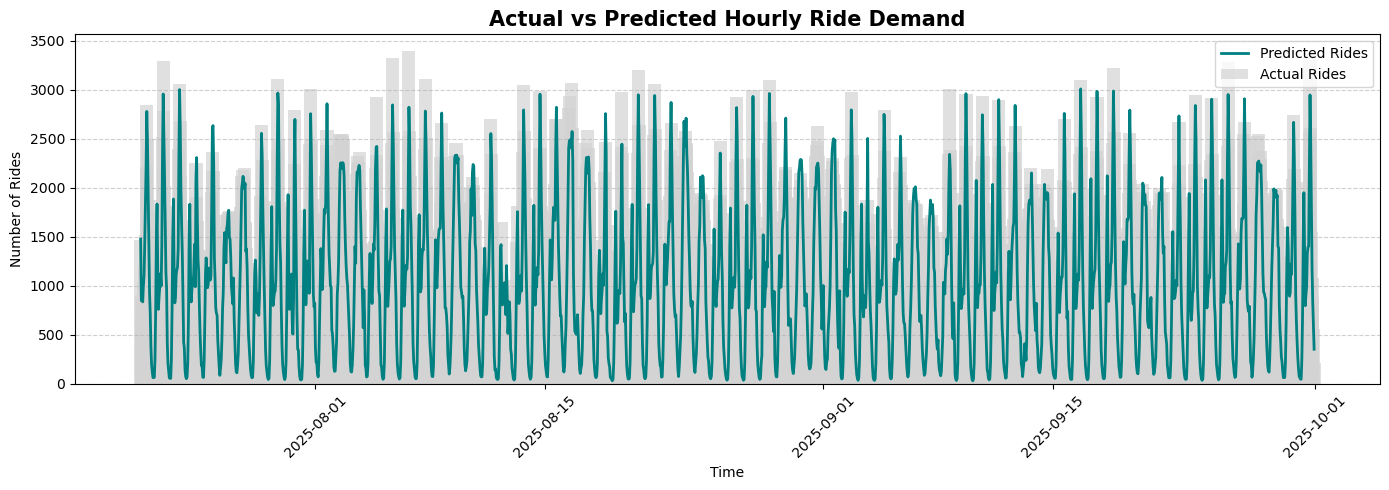

In [28]:
# 📈 Create visualizations to explore data trends

plt.figure(figsize=(14,5))

# Bar chart for actual rides
plt.bar(
    hc['start_ts_hour'].iloc[split_idx:], 
    y_test, 
    color='lightgray', 
    label='Actual Rides', 
    alpha=0.7
)

# Line for predicted rides
plt.plot(
    hc['start_ts_hour'].iloc[split_idx:], 
    y_pred, 
    color='teal', 
    linewidth=2, 
    label='Predicted Rides'
)

# Formatting
plt.title('Actual vs Predicted Hourly Ride Demand', fontsize=15, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Number of Rides')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Demand forecasts for casual vs. member riders

In [77]:
# 🧹 Handle missing or null values in the dataset

daily_rides = df.groupby(['date', 'member_casual']).size().reset_index(name='rides')

# Add lag and rolling features (by user type)
daily_rides = daily_rides.sort_values(['member_casual', 'date'])
daily_rides['lag_1'] = daily_rides.groupby('member_casual')['rides'].shift(1)
daily_rides['lag_7'] = daily_rides.groupby('member_casual')['rides'].shift(7)
daily_rides['rolling_7'] = daily_rides.groupby('member_casual')['rides'].rolling(7).mean().reset_index(0, drop=True)

daily_rides = daily_rides.dropna()

In [78]:
# 🧩 Split the dataset into training and testing sets

models = {}
results = {}

for user_type in ['member', 'casual']:
    df_user = daily_rides[daily_rides['member_casual'] == user_type].copy()

    X = df_user[['lag_1', 'lag_7', 'rolling_7']]
    y = df_user['rides']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    models[user_type] = model
    results[user_type] = {'MAE': mae, 'RMSE': rmse}

print(pd.DataFrame(results))

           member       casual
MAE   1965.962292  1807.578958
RMSE  2396.988279  2345.095468


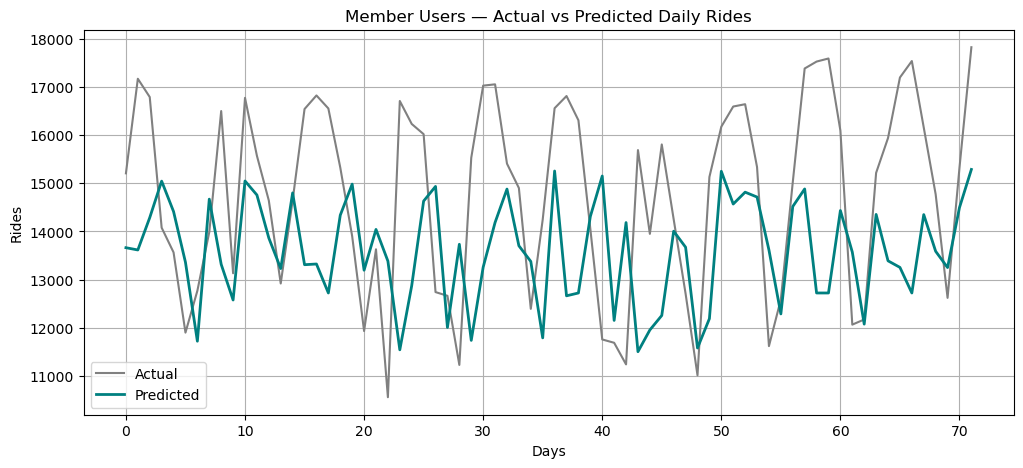

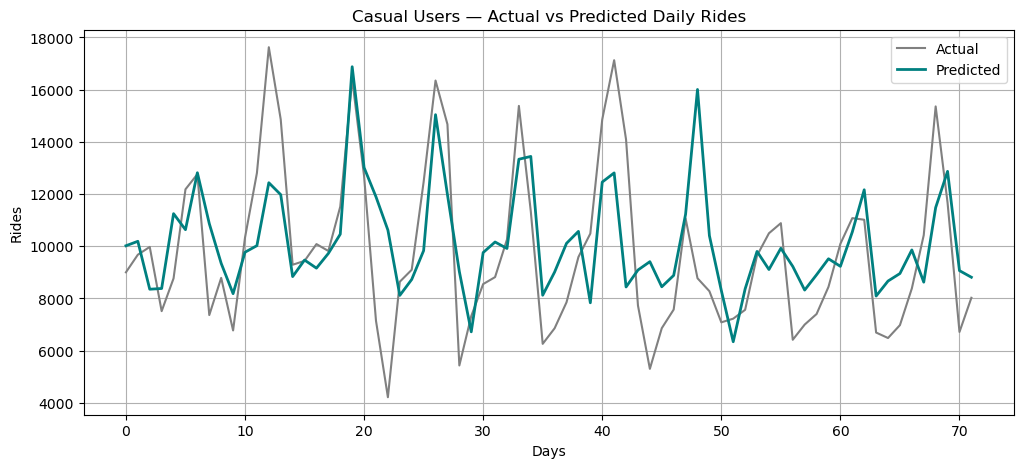

In [79]:
# 📈 Create visualizations to explore data trends

for user_type in ['member', 'casual']:
    df_user = daily_rides[daily_rides['member_casual'] == user_type].copy()
    X = df_user[['lag_1', 'lag_7', 'rolling_7']]
    y = df_user['rides']

    # Split again for plotting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    y_pred = models[user_type].predict(X_test)

    plt.figure(figsize=(12,5))
    plt.plot(y_test.values, label='Actual', color='gray')
    plt.plot(y_pred, label='Predicted', color='teal', linewidth=2)
    plt.title(f'{user_type.capitalize()} Users — Actual vs Predicted Daily Rides')
    plt.xlabel('Days')
    plt.ylabel('Rides')
    plt.legend()
    plt.grid(True)
    plt.show()